In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from itertools import repeat


from snewpy import snowglobes
from astropy import units as u
from snewpy.neutrino import Flavor, MassHierarchy, MixingParameters
from snewpy.models.ccsn import *
from snewpy.flavor_transformation import AdiabaticMSW


SNOwGLoBES_path = "/Users/sierra/Desktop/neutrino_fall_2022/dependencies/snowglobes"
SNEWPY_models_base = "/Users/sierra/Desktop/neutrino_fall_2022/dependencies/SNEWPY_models"  # directory containing SNEWPY models

# set parameters that don't vary over all models
# set distance in kpc
distance = 1.0

# set SNOwGLoBES detector to use
detector = "ar40kt"

# set desired flavor transformation
transformation = 'NoTransformation'

# most of the Fornax simulations have these time scales
window_tstart = 0.1015 # Fornax adjusted time bins
window_tend = 4.1015
window_bins = 800 # .005 s time bin

window_tstart_burst = -0.0505 # Fornax adjusted time bins
window_tend_burst = 0.1015
window_bins_burst = 76 # .002 s time bin

tstart = np.linspace(window_tstart, window_tend, window_bins, endpoint=False) 
tend = tstart + (window_tend - window_tstart) / window_bins 
tmid = (tstart + tend) * 0.5 

tstart_burst = np.linspace(window_tstart_burst, window_tend_burst, window_bins_burst, endpoint=False) 
tend_burst = tstart_burst + (window_tend_burst - window_tstart_burst) / window_bins_burst 
tmid_burst = (tstart_burst + tend_burst) * 0.5 

tstart = np.append(tstart_burst, tstart)
tend = np.append(tend_burst, tend)

# rename factor
change_to_s = window_bins / (window_tend - window_tstart) / 1000
change_to_s_burst = window_bins_burst / (window_tend_burst - window_tstart_burst) / 1000

# number of lines in dat file
num_lines = 500

plt.rcParams.update({'font.size': 16})


In [2]:
# make new colorbar

# opening the file in read mode
new_colorbar = open("/Users/sierra/Desktop/neutrino/colormap_updated.txt", "r")
  
# reading the file
data = new_colorbar.read()
  
# replacing end splitting the text 
# when newline ('\n') is seen.
c = data.split('\n')

new_colorbar.close()

cm_u = mpl.colors.ListedColormap(c)

In [3]:
def get_fluence_and_energy_arrays(energy_inst, fluence_inst, nu_x_fluence, flavor, file_directory):
    sorted_dir = os.listdir(file_directory)
    sorted_dir = sorted(sorted_dir, key=lambda x:float(re.findall("(\d+)", x)[-1]))
    for filename in sorted_dir:
        #print(filename)
        with open(os.path.join(file_directory, filename), 'r') as f:
            nu_x_sum = 0
            next(f)
            next(f) # skip string headers
            next(f) # skip 0 energy bin
            if flavor == "nux":
                for line in f:
                    nu_x_sum += (float(line.split()[2]) + float(line.split()[3]) + float(line.split()[5]) + float(line.split()[6]))
                    energy_inst.append(float(line.split()[0]))
                    fluence_inst.append(float(line.split()[2]) + float(line.split()[3]) + float(line.split()[5]) + float(line.split()[6]))
                nu_x_fluence.append(nu_x_sum)
            if flavor == "nue":
                for line in f:
                    nu_x_sum += float(line.split()[1])
                    energy_inst.append(float(line.split()[0]))
                    fluence_inst.append(float(line.split()[1]))
                nu_x_fluence.append(nu_x_sum)
            if flavor == "anue":
                for line in f:
                    nu_x_sum += float(line.split()[4])
                    energy_inst.append(float(line.split()[0]))
                    fluence_inst.append(float(line.split()[4]))
                nu_x_fluence.append(nu_x_sum)
            if flavor == "all":
                for line in f:
                    nu_x_sum += (float(line.split()[1]) + float(line.split()[2]) + float(line.split()[3]) + float(line.split()[4]) + float(line.split()[5]) + float(line.split()[6]))
                    energy_inst.append(float(line.split()[0]))
                    fluence_inst.append(float(line.split()[1]) + float(line.split()[2]) + float(line.split()[3]) + float(line.split()[4]) + float(line.split()[5]) + float(line.split()[6]))
                nu_x_fluence.append(nu_x_sum)



In [4]:
def sort_by_phase(tstart, window_tend_burst):
    high_res = []
    for i in tstart:
        if i <= window_tend_burst:
            high_res.append(i)
    
    burst, accretion, cooling = [], [], []
    for i in (tstart):
        if i <= 0.06:   #0.1
            burst.append(i)
        if i > 0.06 and i <= 0.5:
            accretion.append(i)
        if i > .5: #i > .5:
            cooling.append(i)
    return burst, accretion, cooling, high_res


def extend_phase(burst, accretion, cooling):
    ext_burst = [x for item in burst for x in repeat(item, num_lines)]
    ext_burst = np.array_split(ext_burst,len(burst))

    ext_accretion = [x for item in accretion for x in repeat(item, num_lines)]
    ext_accretion = np.array_split(ext_accretion,len(accretion))

    ext_cooling = [x for item in cooling for x in repeat(item, num_lines)]
    ext_cooling = np.array_split(ext_cooling,len(cooling))
    
    return ext_burst, ext_accretion, ext_cooling

def shape_and_scale_fluence_energy(fluence_test, energy_test, high_res):
    l = np.array_split(fluence_test,window_bins + window_bins_burst)
    #l = [value * change_to_s_burst for value in l[:len(high_res)]] + [value * change_to_s for value in l[len(high_res):]]
    
    e = np.array_split(energy_test,window_bins + window_bins_burst)
    e = [value * 1000 for value in e] #get to MeV
    
    return l, e

def scale_fluence(l, high_res, change_to_s_burst, change_to_s):
    l = [value * change_to_s_burst for value in l[:len(high_res)-1]] + [value * change_to_s for value in l[len(high_res)-1:]]
    return l
    
    
def formatted_flavor(flavor):
    if flavor == "nux":
        overleaf_flavor = "$\\nu_x$"
    if flavor == "anue":
        overleaf_flavor = "$\\overline{\\nu_e}$"
    if flavor == "nue":
        overleaf_flavor = "$\\nu_e$"
    if flavor == "all":
        overleaf_flavor = "$\\nu_e$, $\\overline{\\nu_e}$, and $\\nu_x$"
    return overleaf_flavor

def plot_projected(adj, tstart, nue_test, ax1, ax2, ax3, local_max_location, overleaf_flavor, burst, accretion, cooling):
    total = len(tstart)
    ax1.plot(tstart[:len(burst) + adj] * u.s, nue_test[local_max_location:len(burst) + local_max_location + adj], label = overleaf_flavor, drawstyle='steps-mid')
    ax2.plot(tstart[len(burst) + adj:len(burst)+len(accretion) + adj] * u.s, nue_test[len(burst) + local_max_location + adj:len(burst)+len(accretion) + local_max_location+ adj], label = overleaf_flavor, drawstyle='steps-mid')
    ax3.plot(tstart[len(burst) + len(accretion) + adj:total -local_max_location + adj] * u.s , nue_test[len(burst) + len(accretion) + local_max_location + adj:total -local_max_location + adj], label = overleaf_flavor, drawstyle='steps-mid')

def normalize_by_peak(test13, burst, relative_to):
    peak_first = np.max(relative_to[:len(burst)])
    peak_second = np.max(relative_to[len(burst):])
    list1 = [value/peak_first for value in test13[:len(burst)]] 
    list2 = [value/(peak_first * 10) for value in test13[len(burst):]]
    list1.extend(list2)
    return list1
    

def find_local_max(all_test, high_res, adjust):
    local_max_location = np.argmax(all_test[:len(high_res)]) - adjust
    return local_max_location


In [5]:

def get_data_and_plot_fluence(flavor, files, mass, model, msw, projection):
    
    all_for_max, test, test1 = [], [], []
    energy_test, fluence_test, nu_x_test = [], [], []
    
    
    get_fluence_and_energy_arrays(test, test1, all_for_max, "all", files)  
    get_fluence_and_energy_arrays(energy_test, fluence_test, nu_x_test, flavor, files)
    
    
    burst, accretion, cooling, high_res = sort_by_phase()
    ext_burst, ext_accretion, ext_cooling = extend_phase(burst, accretion, cooling)
    
    
    # shape fluence
    l, e = shape_and_scale_fluence_energy(fluence_test, energy_test, high_res)
    overleaf_flavor = formatted_flavor(flavor)

    
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 5), tight_layout=True)
    if projection == "integrated":
        nu_x_test = scale_fluence(nu_x_test, high_res)
        local_max = np.max(nu_x_test[:len(high_res) - 1])
        local_max_location = find_local_max(nu_x_test, high_res)

        
        plot_projected(nu_x_test, ax1, ax2, ax3, local_max_location, overleaf_flavor, burst, accretion, cooling)
        ax1.set_ylim(0,local_max * 1.1)
        ax1.margins(0)
        ax2.set_ylim(0,local_max * 1.1)
        ax2.margins(0)
        ax3.set_ylim(0,local_max * 1.1)
        ax3.margins(0)
        ax1.set_ylabel(f"{overleaf_flavor} events per ms")
        
        
    if projection == None:
        # scale the colorbars to be the same for each subplot
        l = scale_fluence(l, high_res)
        local_max = np.max(l[:len(burst) - 1])
        local_min = np.min(l[:len(burst) - 1])
        local_max_location = np.argmax(all_for_max[:len(high_res) - 1]) - 25
        
        pcm1 = ax1.pcolormesh(ext_burst, e[local_max_location:len(burst) + local_max_location], l[local_max_location:len(burst) + local_max_location], cmap = cm_u, vmin = local_min, vmax = local_max)
        pcm2 = ax2.pcolormesh(ext_accretion, e[local_max_location + len(burst):len(accretion) + len(burst) + local_max_location], l[len(burst) + local_max_location:len(accretion) + len(burst) + local_max_location], cmap = cm_u, vmin = local_min, vmax = local_max)
        pcm3 = ax3.pcolormesh(ext_cooling[:-local_max_location], e[len(accretion) + len(burst) + local_max_location:], l[len(accretion) + len(burst) + local_max_location:], cmap = cm_u, vmin = local_min, vmax = local_max)

        ax1.set_ylim(0,50)
        ax2.set_ylim(0,50)        
        ax3.set_ylim(0,50)
        ax1.set_ylabel("Energy (MeV)")
    
    ax1.set_xlabel("Burst phase (t[s])")
    ax2.set_xlabel("Accretion phase (t[s])")
    ax2.set_yticks([])
    ax3.set_xlabel("Cooling phase (t[s])")
    ax3.set_yticks([]) 
    
    plt.suptitle(f'{projection} {overleaf_flavor} fluence from {model} from a {mass} M☉ progenitor, 1kpc away - {msw} effects')
    plt.savefig(f'{projection}_{flavor}_{mass}_{model}_{msw}.png')
    plt.show()
    
 
    if projection == None:
    # draw a new figure and replot the colorbar there
        fig,ax = plt.subplots(figsize=(22,3))
        cbar_cooling = plt.colorbar(pcm1,ax=ax)
        ax.remove()
        cbar_cooling.set_label(f'Fluence from {overleaf_flavor} per ms')
        plt.savefig(f'{flavor}_{mass}_{model}_{msw}_cbar.png',bbox_inches='tight')
    


In [6]:
def get_data_and_plot_all_int_fluence(files, mass, model, msw, tstart):
    nu_x_test, anue_test, nue_test, energy_test, fluence_test, all_test = [], [], [], [], [], []
    
    get_fluence_and_energy_arrays(energy_test, fluence_test, anue_test, "anue", files)
    get_fluence_and_energy_arrays(energy_test, fluence_test, nue_test, "nue", files)
    get_fluence_and_energy_arrays(energy_test, fluence_test, nu_x_test, "nux", files)
    get_fluence_and_energy_arrays(energy_test, fluence_test, all_test, "all", files)
    

    
    burst, accretion, cooling, high_res = sort_by_phase(tstart, 0.1)
    ext_burst, ext_accretion, ext_cooling = extend_phase(burst, accretion, cooling)
    
    anue_test = normalize_by_peak(anue_test, high_res, all_test)
    nue_test = normalize_by_peak(nue_test, high_res, all_test)
    nu_x_test = normalize_by_peak(nu_x_test, high_res, all_test)
    all_test = normalize_by_peak(all_test, high_res, all_test)
    
    # shape fluence
    l, e = shape_and_scale_fluence_energy(fluence_test, energy_test, high_res)
    local_max = np.max(all_test[:len(burst) - 1])

    local_max_location = 0#np.argmax(all_test[:len(high_res) - 1]) - 5

    tstart = [x-.03 for x in tstart]
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 5), tight_layout=True)
    plt.suptitle(f'Fluence by flavor from {model} model from a {mass} M☉ progenitor, 1kpc away - {msw} effects')
    
    plot_projected(0, tstart, nue_test, ax1, ax2, ax3, local_max_location, formatted_flavor("nue"), burst, accretion, cooling)
    plot_projected(0, tstart, anue_test, ax1, ax2, ax3, local_max_location, formatted_flavor("anue"), burst, accretion, cooling)
    plot_projected(0, tstart, nu_x_test, ax1, ax2, ax3, local_max_location, formatted_flavor("nux"), burst, accretion, cooling)
    plot_projected(0, tstart, all_test, ax1, ax2, ax3, local_max_location, formatted_flavor("all"), burst, accretion, cooling)
    
    
    ax1.set_xlabel("Burst phase (t[s])")
    ax1.set_ylabel(f"Scaled events per bin")
    ax1.set_ylim(0,1.1)
    ax1.margins(0)
    #ax1.legend(prop={'size': 17})

    ax2.set_xlabel("Accretion phase (t[s])")
    ax2.set_yticks([])
    ax2.set_ylim(0,1.1)
    ax2.margins(0)
    ax2.legend(prop={'size': 17})

    ax3.set_xlabel("Cooling phase (t[s])")
    ax3.set_yticks([])
    #ax3.set_ylim(0,local_max * 1.1)
    ax3.set_ylim(0,1.1)
    ax3.margins(0)
    #ax3.legend(prop={'size': 17})
    plt.savefig(f'int_all_{mass}_{model}_{msw}.png')
    plt.show()
    


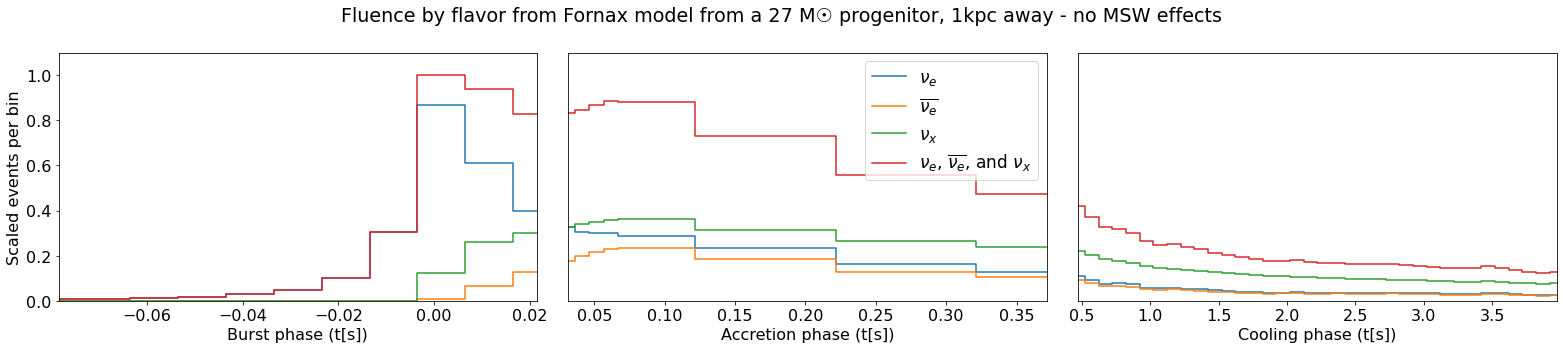

In [7]:
window_tstart = 0.1015 # Fornax adjusted time bins
window_tend = 4.1015
window_bins = 40 # .1 s time bin

window_tstart_burst = -0.0485 # Fornax adjusted time bins
window_tend_burst = 0.1015
window_bins_burst = 15 # .01 s time bin

tstart = np.linspace(window_tstart, window_tend, window_bins, endpoint=False) 
tend = tstart + (window_tend - window_tstart) / window_bins 
tmid = (tstart + tend) * 0.5 

tstart_burst = np.linspace(window_tstart_burst, window_tend_burst, window_bins_burst, endpoint=False) 
tend_burst = tstart_burst + (window_tend_burst - window_tstart_burst) / window_bins_burst 
tmid_burst = (tstart_burst + tend_burst) * 0.5 

tstart = np.append(tstart_burst, tstart)
tend = np.append(tend_burst, tend)

#tstart = [x-.03 for x in tstart]

my_files = "/Users/sierra/neutrino_work/fall_2022_snewpy_project/fluence_runs/fornax_27M_nomsw"
get_data_and_plot_all_int_fluence(my_files, "27", "Fornax", "no MSW", tstart)


In [8]:
def get_data_and_plot_all_int_fluence(files, mass, model, msw, tstart):
    imo, nmo, notransform = [], [], []
    energy_test, fluence_test = [], []

    get_fluence_and_energy_arrays(energy_test, fluence_test, notransform, "nue", "/Users/sierra/neutrino_work/fall_2022_snewpy_project/fluence_runs/fornax_27M_nomsw")
    get_fluence_and_energy_arrays(energy_test, fluence_test, nmo, "nue", "/Users/sierra/neutrino_work/fall_2022_snewpy_project/fluence_runs/fornax_27M")

    get_fluence_and_energy_arrays(energy_test, fluence_test, imo, "nue", "/Users/sierra/neutrino_work/fall_2022_snewpy_project/fluence_runs/fornax_27M_IMO")
    

    
    burst, accretion, cooling, high_res = sort_by_phase(tstart, 0.1)
    ext_burst, ext_accretion, ext_cooling = extend_phase(burst, accretion, cooling)
    
    nmo = normalize_by_peak(nmo, high_res, notransform)
    imo = normalize_by_peak(imo, high_res, notransform)
    notransform = normalize_by_peak(notransform, high_res, notransform)

    
    # shape fluence
    l, e = shape_and_scale_fluence_energy(fluence_test, energy_test, high_res)
    local_max = np.max(notransform[:len(burst) - 1])

    local_max_location = 0#np.argmax(all_test[:len(high_res) - 1]) - 5

    tstart = [x-.03 for x in tstart]
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 5), tight_layout=True)
    plt.suptitle(f'{formatted_flavor("nue")} from {model} model from a {mass} M☉ progenitor, 1kpc away')

    plot_projected(5, tstart, notransform, ax1, ax2, ax3, local_max_location, "No transformation", burst, accretion, cooling)
    plot_projected(5, tstart, nmo, ax1, ax2, ax3, local_max_location, "NMO", burst, accretion, cooling)
    plot_projected(5, tstart, imo, ax1, ax2, ax3, local_max_location, "IMO", burst, accretion, cooling)
    
        
    
    ax1.set_xlabel("Burst phase (t[s])")
    ax1.set_ylabel(f"Scaled events per bin")
    ax1.set_ylim(0,local_max * 1.1)
    ax1.margins(0)
    #ax1.legend(prop={'size': 17})

    ax2.set_xlabel("Accretion phase (t[s])")
    ax2.set_yticks([])
    ax2.set_ylim(0,1.1)
    ax2.margins(0)
    ax2.legend(prop={'size': 17})

    ax3.set_xlabel("Cooling phase (t[s])")
    ax3.set_yticks([])
    #ax3.set_ylim(0,local_max * 1.1)
    ax3.set_ylim(0,1.1)
    ax3.margins(0)
    #ax3.legend(prop={'size': 17})
    plt.savefig(f'int_all_{mass}_{model}_{msw}.png')
    plt.show()
    


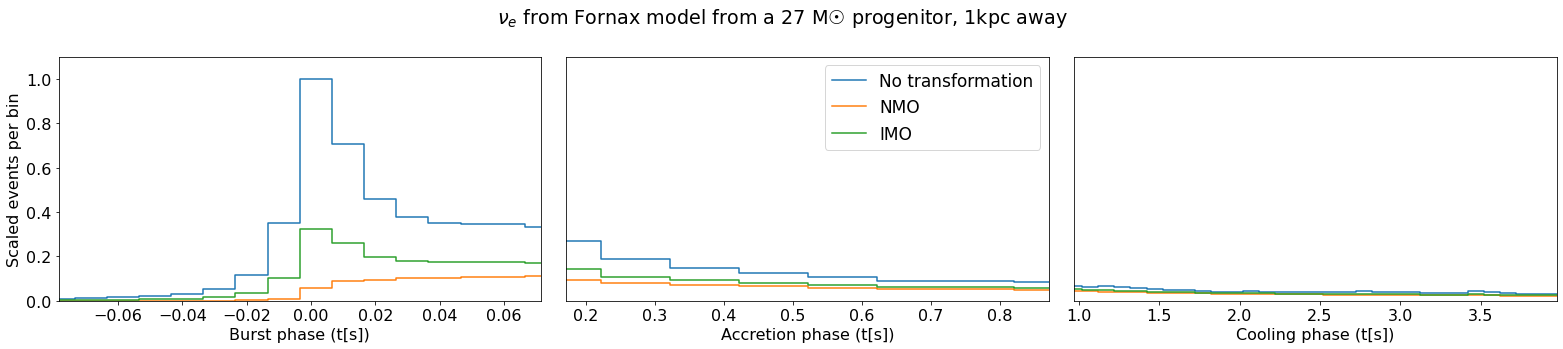

In [9]:
my_files = "/Users/sierra/neutrino_work/fall_2022_snewpy_project/fluence_runs/fornax_27M_nomsw"
get_data_and_plot_all_int_fluence(my_files, "27", "Fornax", "no MSW", tstart)

In [15]:
def get_data_and_plot_all_int_fluence(files, mass, model, msw, tstart):
    imo, nmo, notransform = [], [], []
    energy_test, fluence_test = [], []

    get_fluence_and_energy_arrays(energy_test, fluence_test, nmo, "nux", "/Users/sierra/neutrino_work/fall_2022_snewpy_project/fluence_runs/fornax_27M")

    
    
    burst, accretion, cooling, high_res = sort_by_phase(tstart, 0.1)
    ext_burst, ext_accretion, ext_cooling = extend_phase(burst, accretion, cooling)
    
    nmo = normalize_by_peak(nmo, high_res, nmo)
    

    
    # shape fluence
    l, e = shape_and_scale_fluence_energy(fluence_test, energy_test, high_res)
    local_max = np.max(nmo[:len(burst) - 1])

    local_max_location = 0#np.argmax(all_test[:len(high_res) - 1]) - 5

    tstart = [x-.03 for x in tstart]
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 5), tight_layout=True)
    plt.suptitle(f'{formatted_flavor("nux")} from {model} model from a {mass} M☉ progenitor, 1kpc away')


    plot_projected(0, tstart, nmo, ax1, ax2, ax3, local_max_location, formatted_flavor("nux"), burst, accretion, cooling)
    
        
    
    ax1.set_xlabel("Burst phase (t[s])")
    ax1.set_ylabel(f"Scaled events per bin")
    ax1.set_ylim(0,local_max * 1.1)
    ax1.margins(0)
    #ax1.legend(prop={'size': 17})

    ax2.set_xlabel("Accretion phase (t[s])")
    ax2.set_yticks([])
    ax2.set_ylim(0,1.1)
    ax2.margins(0)
    ax2.legend(prop={'size': 17})

    ax3.set_xlabel("Cooling phase (t[s])")
    ax3.set_yticks([])
    #ax3.set_ylim(0,local_max * 1.1)
    ax3.set_ylim(0,1.1)
    ax3.margins(0)
    #ax3.legend(prop={'size': 17})
    plt.savefig(f'int_all_{mass}_{model}_{msw}.png')
    plt.show()
    


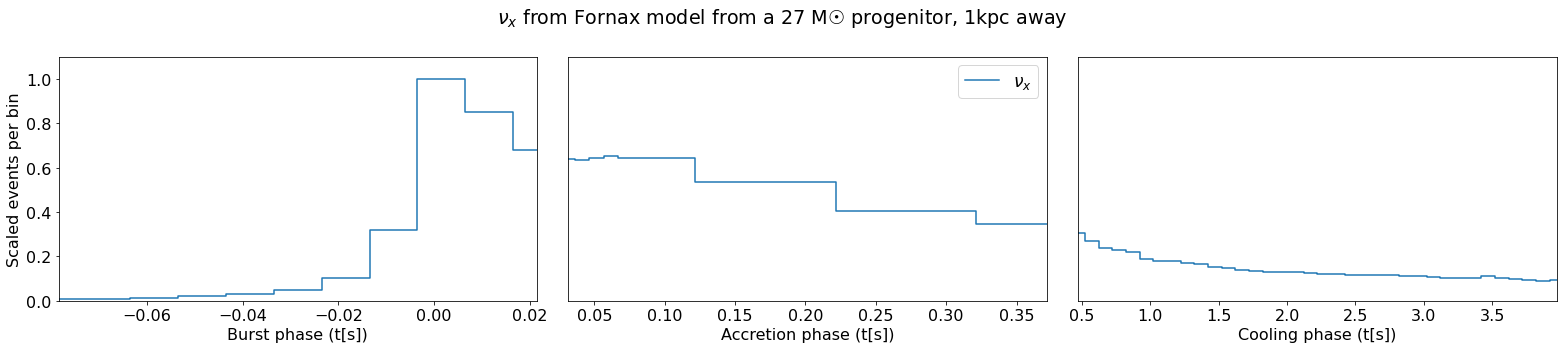

In [16]:
my_files = "/Users/sierra/neutrino_work/fall_2022_snewpy_project/fluence_runs/fornax_27M"
get_data_and_plot_all_int_fluence(my_files, "27", "Fornax", "no MSW", tstart)

In [17]:
def get_data_and_plot_all_int_fluence(files, mass, model, msw, tstart):
    m13, m16, m17, m20, m27 = [], [], [], [], []
    energy_test, fluence_test = [], []

    get_fluence_and_energy_arrays(energy_test, fluence_test, m13, "nux", "/Users/sierra/neutrino_work/fall_2022_snewpy_project/fluence_runs/fornax_13M")
    get_fluence_and_energy_arrays(energy_test, fluence_test, m16, "nux", "/Users/sierra/neutrino_work/fall_2022_snewpy_project/fluence_runs/fornax_16M")
    get_fluence_and_energy_arrays(energy_test, fluence_test, m17, "nux", "/Users/sierra/neutrino_work/fall_2022_snewpy_project/fluence_runs/fornax_17M")
    get_fluence_and_energy_arrays(energy_test, fluence_test, m20, "nux", "/Users/sierra/neutrino_work/fall_2022_snewpy_project/fluence_runs/fornax_20M")
    get_fluence_and_energy_arrays(energy_test, fluence_test, m27, "nux", "/Users/sierra/neutrino_work/fall_2022_snewpy_project/fluence_runs/fornax_27M")
    
    burst, accretion, cooling, high_res = sort_by_phase(tstart, 0.1)
    ext_burst, ext_accretion, ext_cooling = extend_phase(burst, accretion, cooling)
    
    m13 = normalize_by_peak(m13, high_res, m13)
    m16 = normalize_by_peak(m16, high_res, m16)
    m17 = normalize_by_peak(m17, high_res, m17)
    m20 = normalize_by_peak(m20, high_res, m20)
    m27 = normalize_by_peak(m27, high_res, m27)
    

    
    # shape fluence
    l, e = shape_and_scale_fluence_energy(fluence_test, energy_test, high_res)
    local_max = np.max(m27[:len(burst) - 1])

    local_max_location = 0#np.argmax(all_test[:len(high_res) - 1]) - 5

    tstart = [x-.03 for x in tstart]
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 5), tight_layout=True)
    plt.suptitle(f'{formatted_flavor("nux")} from {model} model from various M☉ progenitor, 1kpc away')


    plot_projected(0, tstart, m13, ax1, ax2, ax3, local_max_location, "13M", burst, accretion, cooling)
    plot_projected(0, tstart, m16, ax1, ax2, ax3, local_max_location, "16M", burst, accretion, cooling)
    plot_projected(0, tstart, m17, ax1, ax2, ax3, local_max_location, "17M", burst, accretion, cooling)
    plot_projected(0, tstart, m20, ax1, ax2, ax3, local_max_location, "20M", burst, accretion, cooling)
    plot_projected(0, tstart, m27, ax1, ax2, ax3, local_max_location, "27M", burst, accretion, cooling)
    
    
    ax1.set_xlabel("Burst phase (t[s])")
    ax1.set_ylabel(f"Scaled events per bin")
    ax1.set_ylim(0,local_max * 1.1)
    ax1.margins(0)
    #ax1.legend(prop={'size': 17})

    ax2.set_xlabel("Accretion phase (t[s])")
    ax2.set_yticks([])
    ax2.set_ylim(0,1.1)
    ax2.margins(0)
    ax2.legend(prop={'size': 17})

    ax3.set_xlabel("Cooling phase (t[s])")
    ax3.set_yticks([])
    #ax3.set_ylim(0,local_max * 1.1)
    ax3.set_ylim(0,1.1)
    ax3.margins(0)
    #ax3.legend(prop={'size': 17})
    plt.savefig(f'int_all_{mass}_{model}_{msw}.png')
    plt.show()
    


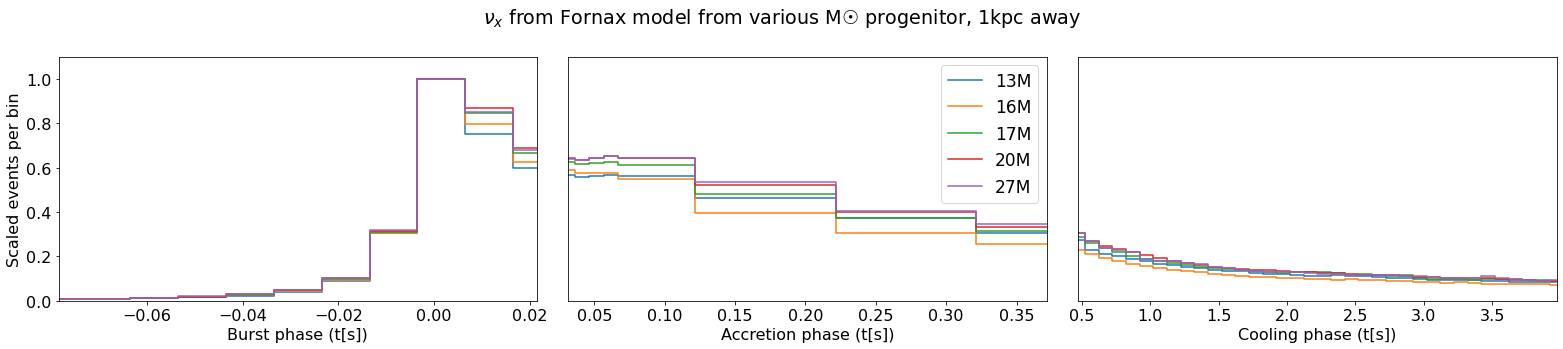

In [18]:
my_files = "/Users/sierra/neutrino_work/fall_2022_snewpy_project/fluence_runs/fornax_27M"
get_data_and_plot_all_int_fluence(my_files, "27", "Fornax", "no MSW", tstart)

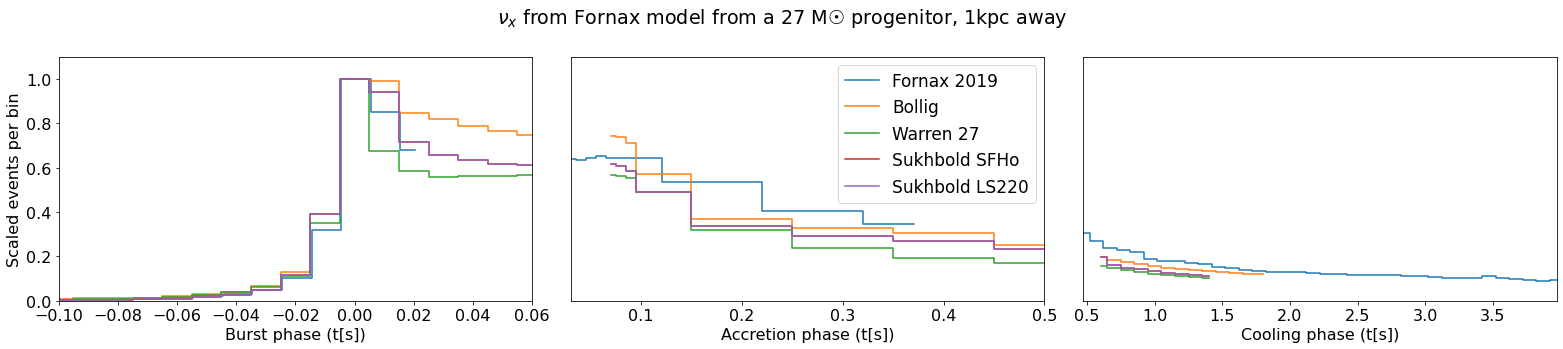

In [27]:
def get_data_and_plot_all_int_fluence(files, mass, model, msw, tstart):
    m13, m16, m17, m20, m27 = [], [], [], [], []
    energy_test, fluence_test = [], []

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 5), tight_layout=True)
    plt.suptitle(f'{formatted_flavor("nux")} from {model} model from a 27 M☉ progenitor, 1kpc away')
    

    local_max_location = 0#np.argmax(all_test[:len(high_res) - 1]) - 5    
  
    # fornax

    window_tstart = 0.1015 # Fornax adjusted time bins
    window_tend = 4.1015
    window_bins = 40 # .1 s time bin

    window_tstart_burst = -0.0485 # Fornax adjusted time bins
    window_tend_burst = 0.1015
    window_bins_burst = 15 # .01 s time bin

    tstart = np.linspace(window_tstart, window_tend, window_bins, endpoint=False) 
    tend = tstart + (window_tend - window_tstart) / window_bins 
    tmid = (tstart + tend) * 0.5 

    tstart_burst = np.linspace(window_tstart_burst, window_tend_burst, window_bins_burst, endpoint=False) 
    tend_burst = tstart_burst + (window_tend_burst - window_tstart_burst) / window_bins_burst 
    tmid_burst = (tstart_burst + tend_burst) * 0.5 

    tstart = np.append(tstart_burst, tstart)
    tend = np.append(tend_burst, tend)
    
    burst, accretion, cooling, high_res = sort_by_phase(tstart, 0.1)
    tstart_mod = [x-.031 for x in tstart]     
    get_fluence_and_energy_arrays(energy_test, fluence_test, m27, "nux", "/Users/sierra/neutrino_work/fall_2022_snewpy_project/fluence_runs/fornax_27M")
    m27 = normalize_by_peak(m27, high_res, m27) 
    plot_projected(0, tstart_mod, m27, ax1, ax2, ax3, local_max_location, "Fornax 2019", burst, accretion, cooling)
    #
    
    # bollig
    
    window_tstart = 0.1 
    window_tend = 1.9
    window_bins = 18

    window_tstart_burst = -0.1 
    window_tend_burst = 0.1
    window_bins_burst = 20
    
    tstart = np.linspace(window_tstart, window_tend, window_bins, endpoint=False) 
    tend = tstart + (window_tend - window_tstart) / window_bins 
    tmid = (tstart + tend) * 0.5 

    tstart_burst = np.linspace(window_tstart_burst, window_tend_burst, window_bins_burst, endpoint=False) 
    tend_burst = tstart_burst + (window_tend_burst - window_tstart_burst) / window_bins_burst 
    tmid_burst = (tstart_burst + tend_burst) * 0.5 

    tstart = np.append(tstart_burst, tstart)
    tend = np.append(tend_burst, tend)

    burst, accretion, cooling, high_res = sort_by_phase(tstart, 0.09)
    tstart_mod = [x-0.0 for x in tstart]     

    
    get_fluence_and_energy_arrays(energy_test, fluence_test, m13, "nux", "/Users/sierra/neutrino_work/fall_2022_snewpy_project/fluence_runs/bollig")
    m13 = normalize_by_peak(m13, high_res, m13)
    plot_projected(0, tstart_mod, m13, ax1, ax2, ax3, local_max_location, "Bollig", burst, accretion, cooling)

    # warren

    window_tstart = 0.1 
    window_tend = 1.5
    window_bins = 14

    window_tstart_burst = -0.1 
    window_tend_burst = 0.1
    window_bins_burst = 20
    
    tstart = np.linspace(window_tstart, window_tend, window_bins, endpoint=False) 
    tend = tstart + (window_tend - window_tstart) / window_bins 
    tmid = (tstart + tend) * 0.5 

    tstart_burst = np.linspace(window_tstart_burst, window_tend_burst, window_bins_burst, endpoint=False) 
    tend_burst = tstart_burst + (window_tend_burst - window_tstart_burst) / window_bins_burst 
    tmid_burst = (tstart_burst + tend_burst) * 0.5 

    tstart = np.append(tstart_burst, tstart)
    tend = np.append(tend_burst, tend)
    
    burst, accretion, cooling, high_res = sort_by_phase(tstart, 0.09)
    tstart_mod = [x-.0 for x in tstart]     
    
    get_fluence_and_energy_arrays(energy_test, fluence_test, m16, "nux", "/Users/sierra/neutrino_work/fall_2022_snewpy_project/fluence_runs/warren_27")
    m16 = normalize_by_peak(m16, high_res, m16)    
    plot_projected(0, tstart_mod, m16, ax1, ax2, ax3, local_max_location, "Warren 27", burst, accretion, cooling)
    
    get_fluence_and_energy_arrays(energy_test, fluence_test, m17, "nux", "/Users/sierra/neutrino_work/fall_2022_snewpy_project/fluence_runs/sukh_sfho")
    m17 = normalize_by_peak(m17, high_res, m17)    
    plot_projected(0, tstart_mod, m17, ax1, ax2, ax3, local_max_location, "Sukhbold SFHo", burst, accretion, cooling)
    
    # sukhbold
    
    get_fluence_and_energy_arrays(energy_test, fluence_test, m20, "nux", "/Users/sierra/neutrino_work/fall_2022_snewpy_project/fluence_runs/sukh_ls220")
    m20 = normalize_by_peak(m20, high_res, m20)    
    plot_projected(0, tstart_mod, m20, ax1, ax2, ax3, local_max_location, "Sukhbold LS220", burst, accretion, cooling)

    




    

    
    # shape fluence
    l, e = shape_and_scale_fluence_energy(fluence_test, energy_test, high_res)






    
    
    ax1.set_xlabel("Burst phase (t[s])")
    ax1.set_ylabel(f"Scaled events per bin")
    ax1.set_ylim(0,1.1)
    ax1.margins(0)
    #ax1.legend(prop={'size': 17})

    ax2.set_xlabel("Accretion phase (t[s])")
    ax2.set_yticks([])
    ax2.set_ylim(0,1.1)
    ax2.margins(0)
    ax2.legend(prop={'size': 17})

    ax3.set_xlabel("Cooling phase (t[s])")
    ax3.set_yticks([])
    #ax3.set_ylim(0,local_max * 1.1)
    ax3.set_ylim(0,1.1)
    ax3.margins(0)
    #ax3.legend(prop={'size': 17})
    plt.savefig(f'int_all_{mass}_{model}_{msw}.png')
    plt.show()
    
my_files = "/Users/sierra/neutrino_work/fall_2022_snewpy_project/fluence_runs/fornax_27M"
get_data_and_plot_all_int_fluence(my_files, "27", "Fornax", "no MSW", tstart)